In [ ]:
# Import dependencies
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn import preprocessing

In [ ]:
# multi feature corpus cannot be published due to copyright reasons
df = pd.read_csv('/SVM Approach/multi-feature_new.csv')
print("Size:", len(df))

# Resample to handle the imbalanced dataset
minority_samples = df["label"].value_counts().tolist()[-1] # number of sample in the lowest category
df_minority = df[df.label == 0]

for i in range(1, 4):
  df_majority = df[df.label == i]

  if i is 2:
    limit_samples = int(minority_samples * 1.4)
  elif i is 1:
    limit_samples = int(minority_samples * 1.1)
  else:
    limit_samples = minority_samples

  # Downsample majority class
  df_majority_downsampled = resample(df_majority, 
                                  replace=False,    # sample without replacement
                                  n_samples=limit_samples,     # to match minority class
                                  random_state=123) # reproducible results

  # Combine minority class with downsampled majority class
  df_minority = pd.concat([df_majority_downsampled, df_minority])

df = df_minority

# Print number of rows for categories
print(df["label"].value_counts())

# Select specific columns as features
columns = [
    "number_of_words",
    "number_of_sentences",
    "abbreviations",
    "abstract_words",
    "anglicism",
    "complicated_words",
    "flesch_score",
    "genitive",
    "gsmog_score",
    "lix_score",
    "long_words",
    "negations",
    "numberals",
    "numbers",
    "passive_voice",
    "relative_clause",
    "roman_numbers",
    "special_characters",
    "specialist_terms",
    "subclauses",
    "subjunctive",
    "two_information_units",
    "wstf_4_score"
    ]

X = df[columns].to_numpy()


# Split dataset into train and test sets
y = df["label"].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

# Scale data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

# Add "label" column again for later usage
columns.append("label")
df = df[columns]

Size: 177023
2    21352
1    16777
3    15252
0    15252
Name: label, dtype: int64


Dataset Size: 54906
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      3030
           1       0.68      0.68      0.68      3408
           2       0.63      0.67      0.64      4259
           3       0.75      0.66      0.70      3030

    accuracy                           0.72     13727
   macro avg       0.73      0.73      0.73     13727
weighted avg       0.72      0.72      0.72     13727

Precision (macro): 0.732032
Recall (macro):    0.726090
F1 score (macro):  0.728029



<Figure size 432x288 with 0 Axes>

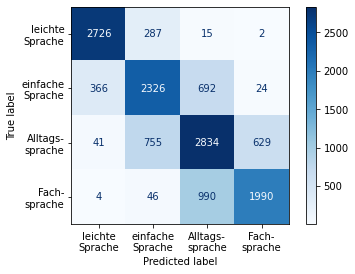

<Figure size 432x288 with 0 Axes>

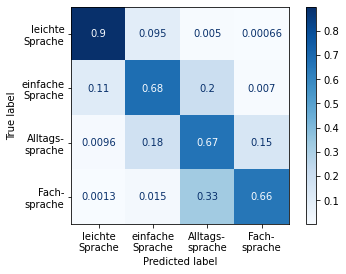

['/content/drive/MyDrive/_Studium/Master/Thesis/Training/SVM Approach/final-model-rbf.pkl']

In [ ]:
####### Final training #######
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import joblib

# Train final network with the best parameters
print("Dataset Size:", len(y_train))

# Best parameter: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
rbf = svm.SVC(kernel='rbf', gamma=0.01, C=1).fit(X_train, y_train)
rbf_pred = rbf.predict(X_test)

# Evaluate model performance
rbf_accuracy = accuracy_score(y_test, rbf_pred)

print("Precision (macro): %f" % precision_score(y_test, rbf_pred, average='macro'))
print("Recall (macro):    %f" % recall_score(y_test, rbf_pred, average='macro'))
print("F1 score (macro):  %f" % f1_score(y_test, rbf_pred, average='macro'), end='\n\n')

# Render confusion matrix
cm_rbf = confusion_matrix(y_test, rbf_pred)
class_names = ["leichte\nSprache", "einfache\nSprache", "Alltags-\nsprache", "Fach-\nsprache"]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("RBF Kernel Confusion matrix, without normalization", None),
    ("RBF Kernel Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    tmp = plt.figure()
    plt.clf()
    disp = ConfusionMatrixDisplay.from_estimator(
        rbf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    #disp.ax_.set_title(title)
    if normalize:
      matrix_type = "normalized"
    else:
      matrix_type = "default"

    plt.savefig('/plots/svm_confusion_matrix_'+matrix_type+'.pdf', bbox_inches='tight')
plt.show()

# Save the model
joblib.dump(rbf, '/SVM Approach/final-model-rbf.pkl', compress=9)